# Восстановление золота из руды

Подготовим прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

План работы:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Описание проекта.

#### Загрузка библиотек.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats as st

from numpy.random import RandomState

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

#### Общие настройки проекта.

In [2]:
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams['figure.figsize'] = (12.0, 9.0)
STATE = RandomState(12345)
BOOTSTRAP_SAMPLES = 1000

#### Пользовательские функции.

In [3]:
#считываем .csv файл, устанавливаем дату / время в кач-ве индекса
def parse_csv(path):
    data = pd.read_csv(path, parse_dates = ['date'])
    data = data.sort_values(by = 'date')
    data.set_index('date', inplace = True)
    return data

In [4]:
#выводим набор типичного инфо для ознакомления с датафреймом
def summary_info(data):
    
    print('Выведем информацию о датафрейме:')
    data.info()
    print()
        
    print('Выведем первые пять строк на экран:')
    display(data.head())
    print()
        
    print('Выведем количество пропусков в столбцах:')
    display((data.isna().mean()*100).to_frame().rename(columns = {0: 'space'}).query('space > 0') \
    .sort_values(by = 'space', ascending = False))
    print()
        
    print('Проверим наличие дубликатов:')
    display(data.duplicated().sum())
    print()
        
    print('Основные статистики по значениям столбцов:')
    display(data.describe())
    print()
            
    print('-----')

In [5]:
#проверка на наличие выбросов
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = (Q3 - Q1) * 1.5
    mean = series.mean()
    median = series.median()
    lower = Q1 - IQR
    upper = Q3 + IQR
    smin = series.min()
    smax = series.max()
    return Q1, Q3, IQR, mean, median, lower, upper, smin, smax

In [6]:
#проверка на наличие выбросов в столбце (возвращает да или нет)
def outliers_in(series):
    Q1, Q3, IQR, mean, median, lower, upper, smin, smax = find_outliers(series)
    return ((smin < lower) or (smax > upper))

In [7]:
#применим класс для упорядоченного хранения данных
class Storage():
    
    #заливаем данные из указанного источника
    def fill_with(self, path):
        
        #данные по указанному пути заливаем в датафрейм только если он пустой
        if self.init.empty:
            self.name = path
            self.init = parse_csv(path)
            print('"{}"'.format(path), 'loaded and saved')
            
        else:
            print('Вызываемый датафрейм уже заполнен.')
    
    #инициализация возможна пустым объектом или при указании пути к источнику загрузкой данных
    def __init__(self, path = ''):
        
        #тут храним стадии обработки данных, инициализируем пустые датафреймы для дальнейшего хранения
        self.name = ''
        self.init = pd.DataFrame()
        
        #если путь загрузки не указан, на этом инициализация заканчивается
        if not path:
            print("ProjectServer.initialised_empty.")
            
        #если путь указан, считаем данные и сохраним по адресу регистрации
        else:
            self.fill_with(path)
            print("ProjectServer.initialised_from_path.")
    
    #дублируем прописанные выше ф-ии методами класса для гибкости в работе
    def outliers_in(self):
        print('Проверим выбросы и аномалии в {}:'.format(self.name))
        for column in list(self.init.columns):
            if outliers_in(self.init[column]):
                print('Выбросы / аномалии в {}'.format(column))
        print()
    
    def summary_info(self):
        print('Выведем сводную информацию по {}'.format(self.name))
        summary_info(self.init)
        print()

## Подготовка данных

Загрузим данные:

In [8]:
train_path = 'gold_recovery_train_new.csv'
train = Storage(train_path)

"gold_recovery_train_new.csv" loaded and saved
ProjectServer.initialised_from_path.


In [9]:
test_path = 'gold_recovery_test_new.csv'
test = Storage(test_path)

"gold_recovery_test_new.csv" loaded and saved
ProjectServer.initialised_from_path.


In [10]:
full_path = 'gold_recovery_full_new.csv'
full = Storage(full_path)

"gold_recovery_full_new.csv" loaded and saved
ProjectServer.initialised_from_path.


Выведем сводное инфо. Поскольку ниже определились со стратегией замены пропусков, а также выбросов / аномалий, сразу произведем замену.

In [11]:
for data in (train, test, full):
    data.summary_info()
    data.outliers_in()

Выведем сводную информацию по gold_recovery_train_new.csv
Выведем информацию о датафрейме:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol          

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,...,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,...,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79
2016-01-15 02:00:00,6.06,10.21,5.38,42.66,68.12,10.51,0.95,16.21,2.26,123.82,...,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43
2016-01-15 03:00:00,6.05,9.98,4.86,42.69,68.35,10.42,0.88,16.53,2.15,122.27,...,14.04,-500.86,12.00,-501.19,9.97,-499.20,7.98,-500.26,14.01,-600.00
2016-01-15 04:00:00,6.15,10.14,4.94,42.77,66.93,10.36,0.79,16.53,2.06,117.99,...,14.03,-499.84,11.95,-501.05,9.93,-501.69,7.89,-500.36,14.00,-601.50



Выведем количество пропусков в столбцах:


,space
secondary_cleaner.output.tail_sol,11.34
rougher.state.floatbank10_e_air,3.08
rougher.input.floatbank11_xanthate,3.02
primary_cleaner.output.concentrate_sol,2.02
secondary_cleaner.state.floatbank2_a_air,1.53
...,...
rougher.state.floatbank10_a_air,0.01
rougher.state.floatbank10_a_level,0.01
rougher.state.floatbank10_b_air,0.01
rougher.state.floatbank10_b_level,0.01



Проверим наличие дубликатов:


0


Основные статистики по значениям столбцов:


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.00,14148.00,13938.00,14149.00,14149.00,14149.00,14049.00,14144.00,14149.00,14129.00,...,14143.00,14148.00,14148.00,14148.00,14148.00,14148.00,14148.00,14148.00,14147.00,14148.00
mean,5.14,10.13,9.20,44.00,66.52,9.61,2.60,10.51,2.92,133.32,...,19.99,-478.70,15.49,-460.23,16.78,-483.96,13.06,-483.97,19.58,-506.80
std,1.37,1.65,2.79,4.91,10.30,2.32,0.97,3.00,0.90,39.43,...,5.66,50.74,5.26,58.84,5.83,37.89,5.77,39.21,5.76,37.08
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,-799.71,0.00,-799.89,-0.37,-797.14,0.65,-800.01,0.20,-809.40
25%,4.21,9.30,7.48,43.28,62.55,8.00,1.91,8.81,2.37,107.01,...,14.99,-500.63,11.89,-500.15,11.08,-500.36,8.99,-500.11,14.99,-500.75
50%,4.99,10.30,8.85,44.87,67.43,9.48,2.59,10.51,2.85,133.02,...,20.00,-499.68,14.98,-499.39,17.93,-499.70,12.00,-499.91,19.98,-500.06
75%,5.86,11.17,10.49,46.17,72.35,11.00,3.24,11.93,3.43,159.83,...,24.99,-477.47,20.06,-400.04,21.35,-487.71,17.98,-453.19,24.99,-499.54
max,16.00,17.03,18.12,52.76,100.00,19.55,5.64,22.32,8.20,250.13,...,30.12,-245.24,24.01,-145.07,43.71,-275.07,27.93,-157.40,32.19,-104.43



-----

Проверим выбросы и аномалии в gold_recovery_train_new.csv:
Выбросы / аномалии в final.output.concentrate_ag
Выбросы / аномалии в final.output.concentrate_pb
Выбросы / аномалии в final.output.concentrate_sol
Выбросы / аномалии в final.output.concentrate_au
Выбросы / аномалии в final.output.recovery
Выбросы / аномалии в final.output.tail_ag
Выбросы / аномалии в final.output.tail_pb
Выбросы / аномалии в final.output.tail_sol
Выбросы / аномалии в final.output.tail_au
Выбросы / аномалии в primary_cleaner.input.sulfate
Выбросы / аномалии в primary_cleaner.input.depressant
Выбросы / аномалии в primary_cleaner.input.feed_size
Выбросы / аномалии в primary_cleaner.input.xanthate
Выбросы / аномалии в primary_cleaner.output.concentrate_ag
Выбросы / аномалии в primary_cleaner.output.concentrate_pb
Выбросы / аномалии в primary_cleaner.output.concentrate_sol
Выбросы / аномалии в primary_cleaner.output.concentrate_au
Выбросы / аномалии в primary_cleaner.output.tail_ag
Выбросы / аномалии в prim

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.80,14.99,8.08,1.01,1398.98,-500.23,1399.14,-499.92,1400.10,-500.70,...,12.02,-497.80,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71
2016-09-01 01:59:59,215.39,14.99,8.08,0.99,1398.78,-500.06,1398.06,-499.78,1396.15,-499.24,...,12.06,-498.70,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82
2016-09-01 02:59:59,215.26,12.88,7.79,1.00,1398.49,-500.87,1398.86,-499.76,1398.08,-502.15,...,11.96,-498.77,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62
2016-09-01 03:59:59,215.34,12.01,7.64,0.86,1399.62,-498.86,1397.44,-499.21,1400.13,-498.36,...,12.03,-498.35,8.07,-499.47,7.90,-500.87,4.93,-499.96,24.95,-498.71
2016-09-01 04:59:59,199.10,10.68,7.53,0.81,1401.27,-500.81,1398.13,-499.50,1402.17,-500.81,...,12.03,-500.79,8.05,-500.40,8.11,-509.53,4.96,-500.36,25.00,-500.86



Выведем количество пропусков в столбцах:


,space
rougher.input.floatbank11_xanthate,0.47
rougher.input.feed_sol,0.40
secondary_cleaner.state.floatbank3_a_air,0.17
rougher.input.floatbank11_sulfate,0.15
primary_cleaner.input.depressant,0.09
rougher.input.floatbank10_sulfate,0.09
primary_cleaner.input.sulfate,0.08
primary_cleaner.input.xanthate,0.08
rougher.input.feed_rate,0.06
secondary_cleaner.state.floatbank2_a_air,0.06



Проверим наличие дубликатов:


0


Основные статистики по значениям столбцов:


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.00,5285.00,5290.00,5286.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,...,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00
mean,174.84,8.68,7.27,1.38,1539.49,-497.67,1545.17,-500.27,1527.27,-498.33,...,16.32,-505.14,13.74,-463.35,12.80,-501.33,9.88,-495.66,17.30,-501.79
std,43.03,3.07,0.61,0.64,116.80,19.95,122.22,32.97,122.54,21.96,...,3.49,31.43,3.43,86.19,3.03,17.95,2.87,34.54,4.54,39.04
min,2.57,0.00,5.65,0.00,0.00,-795.32,0.00,-800.00,0.00,-799.96,...,0.00,-799.80,0.00,-800.84,0.07,-797.32,0.53,-800.22,-0.08,-809.74
25%,147.12,6.49,6.89,0.91,1498.94,-500.36,1498.97,-500.70,1473.23,-501.02,...,14.04,-500.87,12.03,-500.32,10.91,-500.73,8.04,-500.19,14.00,-500.69
50%,177.83,8.05,7.25,1.20,1585.13,-499.97,1595.62,-500.03,1549.59,-500.02,...,17.01,-500.12,14.96,-499.58,12.95,-499.99,10.00,-499.99,16.01,-500.01
75%,208.13,10.03,7.60,1.80,1602.08,-499.57,1602.32,-499.29,1601.14,-498.99,...,18.04,-499.40,15.96,-400.93,15.10,-499.28,12.00,-499.72,21.02,-499.37
max,265.98,40.00,15.50,4.10,2103.10,-57.20,1813.08,-142.53,1715.05,-150.94,...,30.05,-401.57,31.27,-6.51,25.26,-244.48,14.09,-137.74,26.71,-123.31



-----

Проверим выбросы и аномалии в gold_recovery_test_new.csv:
Выбросы / аномалии в primary_cleaner.input.sulfate
Выбросы / аномалии в primary_cleaner.input.depressant
Выбросы / аномалии в primary_cleaner.input.feed_size
Выбросы / аномалии в primary_cleaner.input.xanthate
Выбросы / аномалии в primary_cleaner.state.floatbank8_a_air
Выбросы / аномалии в primary_cleaner.state.floatbank8_a_level
Выбросы / аномалии в primary_cleaner.state.floatbank8_b_air
Выбросы / аномалии в primary_cleaner.state.floatbank8_b_level
Выбросы / аномалии в primary_cleaner.state.floatbank8_c_air
Выбросы / аномалии в primary_cleaner.state.floatbank8_c_level
Выбросы / аномалии в primary_cleaner.state.floatbank8_d_air
Выбросы / аномалии в primary_cleaner.state.floatbank8_d_level
Выбросы / аномалии в rougher.input.feed_ag
Выбросы / аномалии в rougher.input.feed_pb
Выбросы / аномалии в rougher.input.feed_rate
Выбросы / аномалии в rougher.input.feed_size
Выбросы / аномалии в rougher.input.feed_sol
Выбросы / аномал

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,...,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,...,13.99,-505.50,11.95,-501.33,10.04,-500.17,7.98,-500.58,14.00,-599.79
2016-01-15 02:00:00,6.06,10.21,5.38,42.66,68.12,10.51,0.95,16.21,2.26,123.82,...,14.02,-502.52,11.91,-501.13,10.07,-500.13,8.01,-500.52,14.03,-601.43
2016-01-15 03:00:00,6.05,9.98,4.86,42.69,68.35,10.42,0.88,16.53,2.15,122.27,...,14.04,-500.86,12.00,-501.19,9.97,-499.20,7.98,-500.26,14.01,-600.00
2016-01-15 04:00:00,6.15,10.14,4.94,42.77,66.93,10.36,0.79,16.53,2.06,117.99,...,14.03,-499.84,11.95,-501.05,9.93,-501.69,7.89,-500.36,14.00,-601.50



Выведем количество пропусков в столбцах:


,space
secondary_cleaner.output.tail_sol,8.99
rougher.input.floatbank11_xanthate,2.33
rougher.state.floatbank10_e_air,2.24
primary_cleaner.output.concentrate_sol,1.90
secondary_cleaner.state.floatbank2_a_air,1.13
...,...
primary_cleaner.state.floatbank8_c_level,0.01
primary_cleaner.state.floatbank8_b_level,0.01
primary_cleaner.state.floatbank8_a_level,0.01
final.output.tail_ag,0.01



Проверим наличие дубликатов:


0


Основные статистики по значениям столбцов:


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.00,19438.00,19228.00,19439.00,19439.00,19438.00,19338.00,19433.00,19439.00,19415.00,...,19433.00,19438.00,19438.00,19438.00,19438.00,19438.00,19438.00,19438.00,19437.00,19438.00
mean,5.17,9.98,9.50,44.08,67.05,9.69,2.71,10.58,3.04,144.62,...,18.99,-485.89,15.01,-461.08,15.69,-488.68,12.20,-487.15,18.96,-505.44
std,1.37,1.67,2.79,5.13,10.13,2.33,0.95,2.87,0.92,44.46,...,5.41,47.76,4.89,67.41,5.51,34.53,5.33,38.35,5.55,37.69
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,-799.80,0.00,-800.84,-0.37,-797.32,0.53,-800.22,-0.08,-809.74
25%,4.25,9.14,7.72,43.40,63.30,8.06,2.04,8.94,2.46,114.11,...,14.98,-500.70,11.94,-500.19,10.99,-500.46,8.97,-500.13,14.98,-500.73
50%,5.07,10.10,9.22,45.01,68.17,9.74,2.75,10.62,2.98,143.23,...,18.02,-499.84,14.97,-499.46,15.00,-499.80,11.02,-499.94,19.96,-500.05
75%,5.90,11.04,10.95,46.28,72.69,11.13,3.33,12.10,3.57,175.08,...,23.01,-498.25,19.03,-400.12,18.03,-498.38,14.02,-499.44,24.00,-499.50
max,16.00,17.03,19.62,52.76,100.00,19.55,5.80,22.32,8.25,265.98,...,30.12,-245.24,31.27,-6.51,43.71,-244.48,27.93,-137.74,32.19,-104.43



-----

Проверим выбросы и аномалии в gold_recovery_full_new.csv:
Выбросы / аномалии в final.output.concentrate_ag
Выбросы / аномалии в final.output.concentrate_pb
Выбросы / аномалии в final.output.concentrate_sol
Выбросы / аномалии в final.output.concentrate_au
Выбросы / аномалии в final.output.recovery
Выбросы / аномалии в final.output.tail_ag
Выбросы / аномалии в final.output.tail_pb
Выбросы / аномалии в final.output.tail_sol
Выбросы / аномалии в final.output.tail_au
Выбросы / аномалии в primary_cleaner.input.sulfate
Выбросы / аномалии в primary_cleaner.input.depressant
Выбросы / аномалии в primary_cleaner.input.feed_size
Выбросы / аномалии в primary_cleaner.input.xanthate
Выбросы / аномалии в primary_cleaner.output.concentrate_ag
Выбросы / аномалии в primary_cleaner.output.concentrate_pb
Выбросы / аномалии в primary_cleaner.output.concentrate_sol
Выбросы / аномалии в primary_cleaner.output.concentrate_au
Выбросы / аномалии в primary_cleaner.output.tail_ag
Выбросы / аномалии в prima

В первую очередь необходимо заполнить пропуски данных: в задании однозначно указано, что близкие по времени наблюдения объекты имеют схожие характеристики. Метод .fillna() предлагает параматр 'method', подходящий к ситуации.

In [12]:
for data in (train, test, full):
    data.init = data.init.fillna(method="ffill")

Проверим корректность вычисления к-та 'recovery' на обучающей выборке.

In [13]:
def recovery_calc(data):
    C = data.init['rougher.output.concentrate_au']
    F = data.init['rougher.input.feed_au']
    T = data.init['rougher.output.tail_au']
    first = C * (F - T)
    second = F * (C - T)
    data.init['recovery_ratio'] = (first / second) * 100

In [14]:
recovery_calc(train)

Рассчитаем MAE соотв. ф-ией библиотеки sklearn.

In [15]:
y_true = train.init['rougher.output.recovery']
y_pred = train.init['recovery_ratio']
print(mean_absolute_error(y_true, y_pred))

9.73512347450521e-15


Минус 15я степень величины ошибки. Кажется, это очень неплохо.

Какой мы можем сделать вывод? На комбинате умеют считать, наверное.

Проанализируем признаки, недоступные на тестовой выборке. Выведем "разницу":

In [16]:
train.init.columns.difference(test.init.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'recovery_ratio', 'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_so

Как видим, полностью отсутствую колонки, относящиеся к final (итоговые параметры переработки).

Для первой очистки отсутствуют сведения о разделении продукта на концентраты и хвосты.

Для флотации отсутствуют расчетные показатели ('calculations'), а также сведения о разделении на концентрат и хвосты.

Для второй очистки отсутствуют сведения о хвостах.

Можем сделать вывод (или, скорее, обоснованное предположение), что речь идет об отсутствии в реальном времени доступа к текущим значениям расчетных величин. В частности, после завершения процесса требуется время, чтобы посчитать значения для концентрата и хвостов и обратным путем "восстановить" соответствующие значения на предыдущих этапах.

Если проанализировать наименования столбцов, имеющихся в датафрейме test в порядке прохождения этапов обработки обработки видим, что имеются сведения о подаче материала на флотацию, о состоянии среды флотационных машин, сведения о разделении на концентрат и хвосты на выходе из флотации отсутствуют, на первичную обработку имеем сведения о подаче только в отношении подаваемых реагентов, а также о состоянии этапа первичной очистки. В отношении вторичной очистки имеем только сведения о состоянии.

В итоге можем сделать вывод, что имеется наглядное разделение на онлайн- и оффлайн метрики.

***Вывод:***

Переименование столбцов, изменение типов данных не требуется, дубликаты отсутствуют, пропуски заполнили.

Выбросы и аномалии обработаем ниже при необходимости.

Можем перейти к следующему разделу.

## Анализ данных

Сравним концентрацию металлов на каждом из производственных этапов. Используем боксплот.

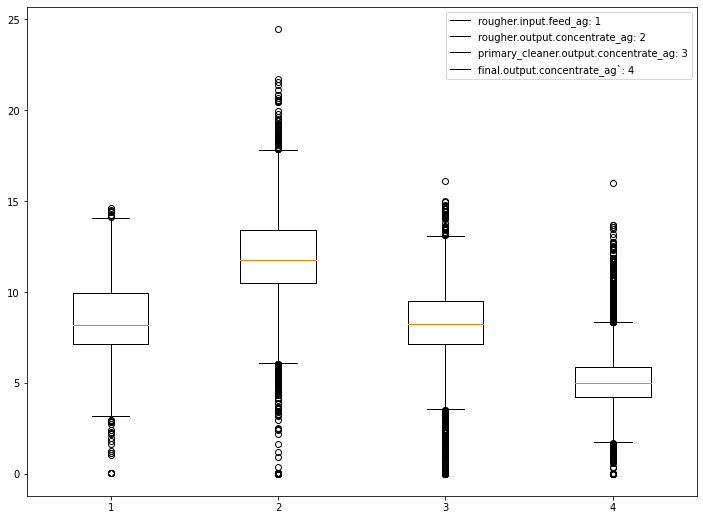

In [17]:
plt.boxplot(x = train.init[['rougher.input.feed_ag', 'rougher.output.concentrate_ag',
                               'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']])
plt.legend(['rougher.input.feed_ag: 1', 'rougher.output.concentrate_ag: 2',
                               'primary_cleaner.output.concentrate_ag: 3', 'final.output.concentrate_ag`: 4'])

plt.show()

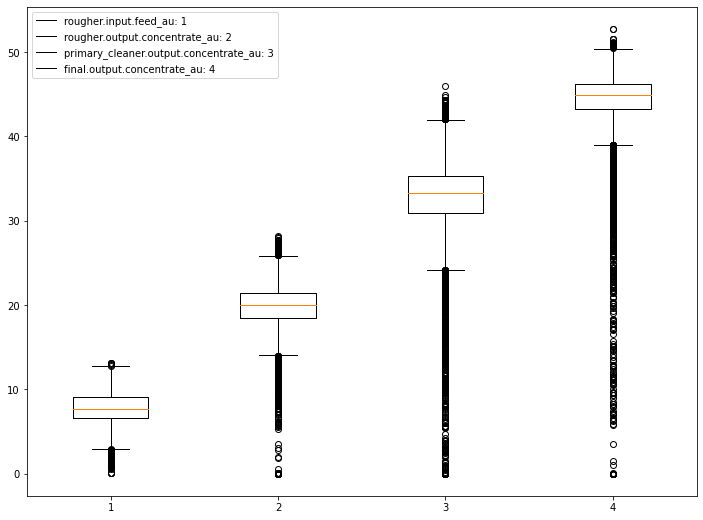

In [18]:
plt.boxplot(x = train.init[['rougher.input.feed_au', 'rougher.output.concentrate_au',
                               'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']])
plt.legend(['rougher.input.feed_au: 1', 'rougher.output.concentrate_au: 2',
                               'primary_cleaner.output.concentrate_au: 3', 'final.output.concentrate_au: 4'])
plt.show()

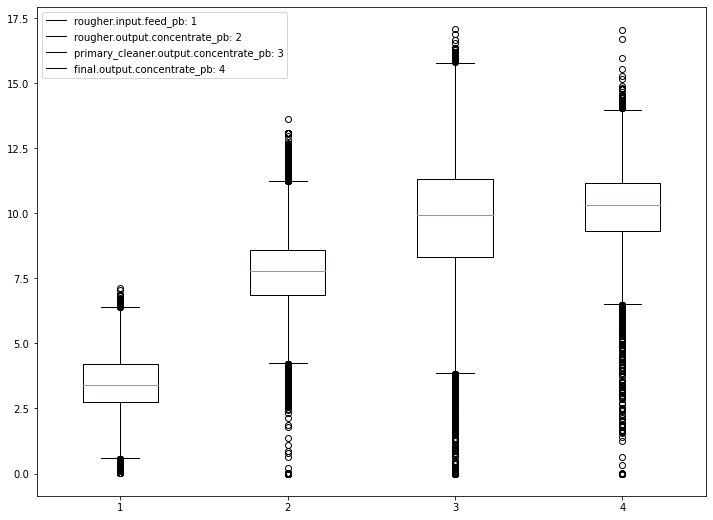

In [19]:
plt.boxplot(x = train.init[['rougher.input.feed_pb', 'rougher.output.concentrate_pb',
                               'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']])
plt.legend(['rougher.input.feed_pb: 1', 'rougher.output.concentrate_pb: 2',
                               'primary_cleaner.output.concentrate_pb: 3', 'final.output.concentrate_pb: 4'])
plt.show()

Концентрация серебра растет после флотации и последовательно снижается на следующих этапах.

На каждом этапе концентрация золота растет.

Концентрация свинца также растет на каждом этапе.

Далее сравним распределение размера гранулы сырья на обучающей и тестовой выборках.

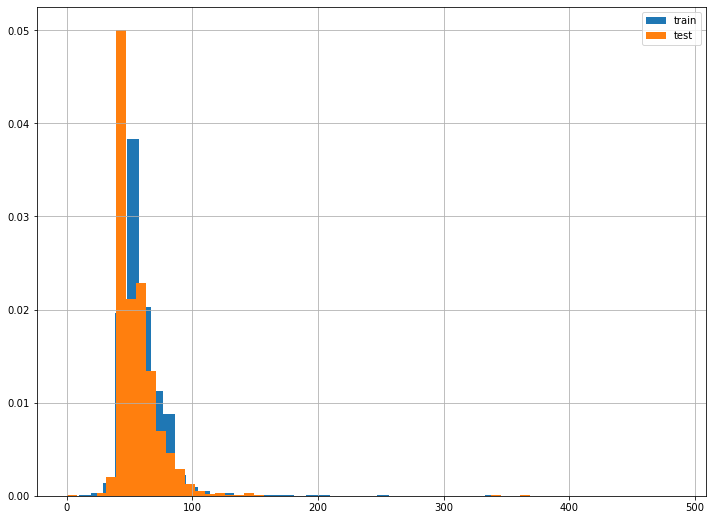

In [20]:
train.init['rougher.input.feed_size'].hist(bins = 50, label = 'train', density = True)
test.init['rougher.input.feed_size'].hist(bins = 50, label = 'test', density = True)
plt.legend()
plt.show()

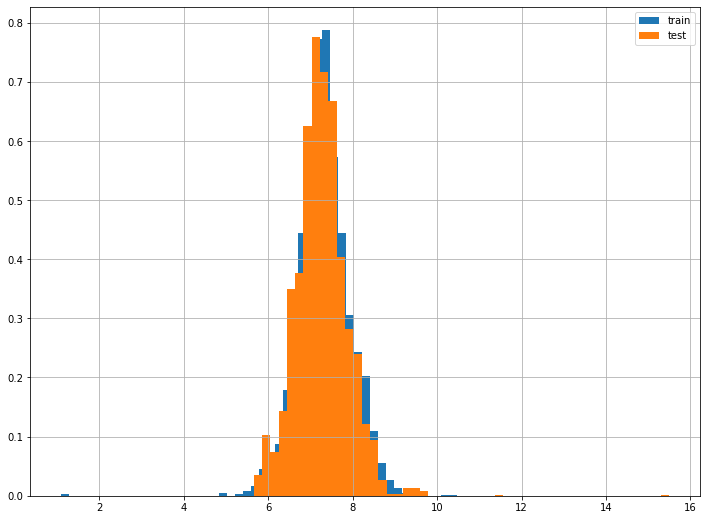

In [21]:
train.init['primary_cleaner.input.feed_size'].hist(bins = 50, label = 'train', density = True)
test.init['primary_cleaner.input.feed_size'].hist(bins = 50, label = 'test', density = True)
plt.legend()
plt.show()

Визуально распределения кажутся похожими: смещения, хвосты, близко расположена мода.

Применим тестирование гипотез.

Нулевая гипотеза заключается в том, что две выборки идентичны.

Если в результате тестирования не сможем подтвердить нулевую гипотезу, значит различия между выборками слишком велики.

In [22]:
sample_before = train.init['rougher.input.feed_size']
sample_after = test.init['rougher.input.feed_size']
print("Cреднее train:", sample_before.mean())
print("Cреднее test:", sample_after.mean())
alpha = 0.05
results = st.ttest_ind(sample_before, sample_after, equal_var = False)
pvalue = results.pvalue
print('p-значение: ', pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Cреднее train: 60.23985599255736
Cреднее test: 55.95275402889511
p-значение:  3.134338776805464e-39
Отвергаем нулевую гипотезу


Применим сэмплинг и бутстреп, чтобы посмотреть немного глубже.

In [23]:
means_list1 = []
for _ in range(BOOTSTRAP_SAMPLES):
    sample1 = sample_before.sample(frac = 1, replace = True, random_state = STATE)
    means_list1.append(sample1.mean())

means_list2 = []
for _ in range(BOOTSTRAP_SAMPLES):
    sample2 = sample_after.sample(frac = 1, replace = True, random_state = STATE)
    means_list2.append(sample2.mean())

Гистограммы распределения средних значений.

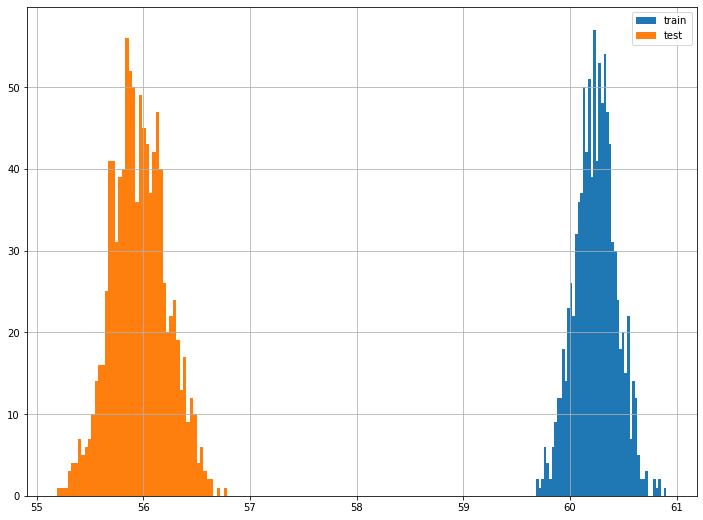

In [24]:
pd.Series(means_list1).hist(bins = 50, label = 'train')
pd.Series(means_list2).hist(bins = 50, label = 'test')
plt.legend()
plt.show()

У обучающей выборки более толстый правый хвост, но в целом, разброс накрывает тестовую, критично было бы если было наоборот.

Ниже повторим для размера сырья на подаче в очистку.

In [25]:
sample_before = train.init['primary_cleaner.input.feed_size']
sample_after = test.init['primary_cleaner.input.feed_size']
print("Cреднее train:", sample_before.mean())
print("Cреднее test:", sample_after.mean())

# критический уровень статистической значимости
alpha = 0.05
results = st.ttest_ind(sample_before, sample_after, equal_var = False)
pvalue = results.pvalue
print('p-значение: ', pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Cреднее train: 7.322309906901298
Cреднее test: 7.266339191270909
p-значение:  1.3721938409942596e-08
Отвергаем нулевую гипотезу


Аналогичный вывод: У обучающей выборки более толстый правый хвост, но в целом, разброс накрывает тестовую, критично было бы если было наоборот.

Исследуем суммарную концентрацию всех веществ на разных стадиях в сырье и концентрате.

In [26]:
data = train.init[['rougher.input.feed_ag',
                  'rougher.input.feed_pb',
                  'rougher.input.feed_au',
                  'rougher.input.feed_sol']].sum(axis = 1)

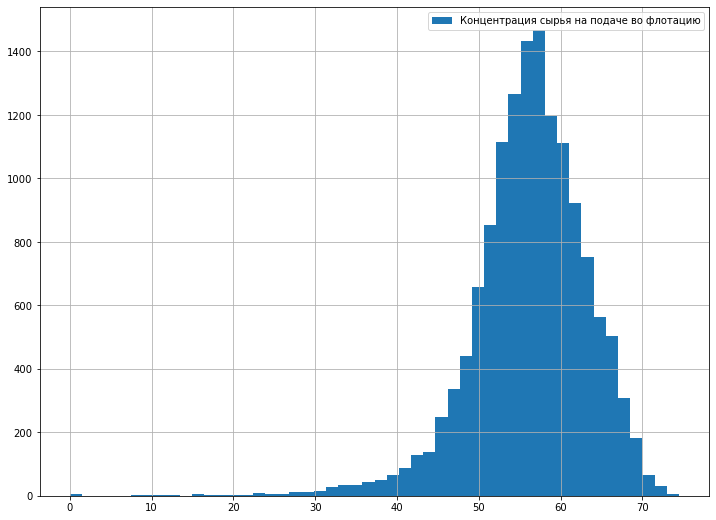

In [27]:
data.hist(bins = 50, label = 'Концентрация сырья на подаче во флотацию')
plt.legend()
plt.show()

In [28]:
data = train.init[['rougher.output.concentrate_ag',
                  'rougher.output.concentrate_pb',
                  'rougher.output.concentrate_au',
                  'rougher.output.concentrate_sol']].sum(axis = 1)

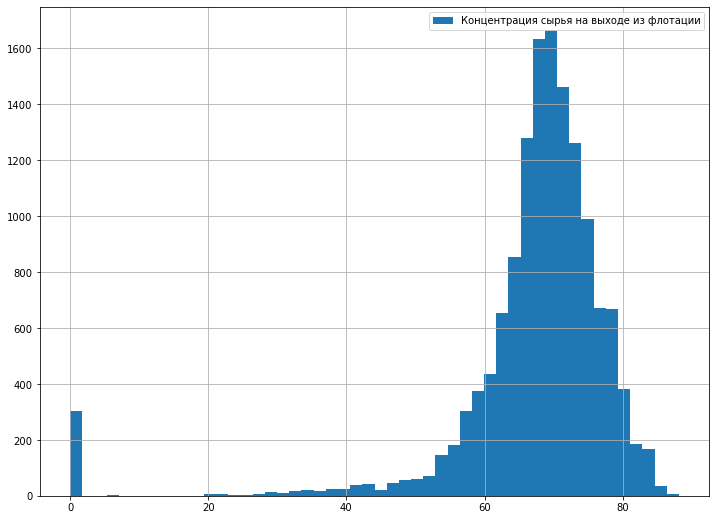

In [29]:
data.hist(bins = 50, label = 'Концентрация сырья на выходе из флотации')
plt.legend()
plt.show()

In [30]:
data = train.init[['primary_cleaner.output.concentrate_ag',
                  'primary_cleaner.output.concentrate_pb',
                  'primary_cleaner.output.concentrate_au',
                  'primary_cleaner.output.concentrate_sol']].sum(axis=1)

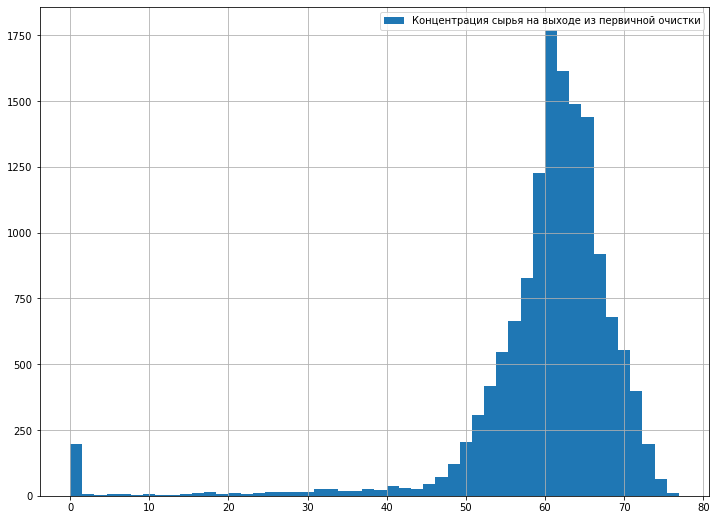

In [31]:
data.hist(bins = 50, label = 'Концентрация сырья на выходе из первичной очистки')
plt.legend()
plt.show()

In [32]:
data = train.init[['final.output.concentrate_ag',
                  'final.output.concentrate_pb',
                  'final.output.concentrate_au',
                  'final.output.concentrate_sol']].sum(axis = 1)

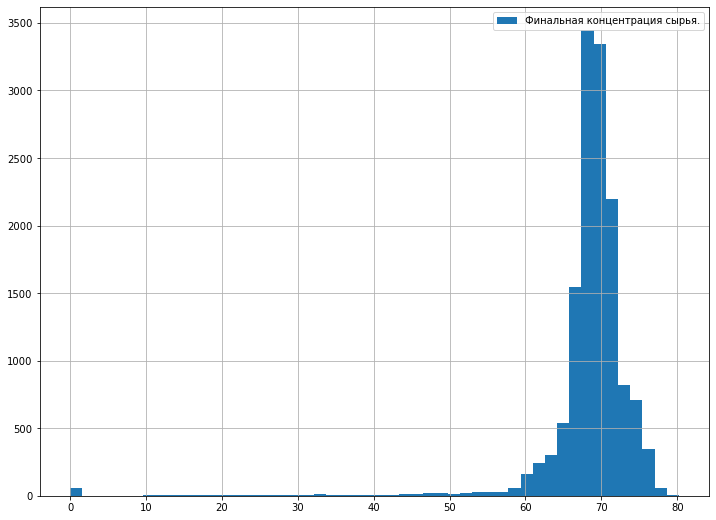

In [33]:
data.hist(bins = 50, label = 'Финальная концентрация сырья.')
plt.legend()
plt.show()

Обработку выбросов / аномалий проведем в рамках обучения моделей, чтобы иметь возможность оценить влияние разных подходов на результат.

## Модель

Повторим задачу: построить модель, прогнозирующую к-т recovery. В качестве метрики используем sMAPE.

Исходные данные: датасет трейн. Датасет тест. И датасет фулл. На текущем этапе в исходные датасеты было внесено только одно изменение: заполнены пропуски. Кроме того, в трейн датасете добавлен столбец recovery_ratio при проверке корректности расчета. В остальном данные сохранены нетронутыми.

На трейн датасете имеются как признаки, так и таргет. На тестовом датасете таргет отстутствует. На фулл датасете имеется полный набор признаки и таргет.

Для расчета итоговой метрики sMAPE нужно предварительно рассчитать sMAPE для корректности предсказания коэффициента восстановления после окончания флотации, а также отдельно sMAPE для финального к-та восстановления.

Процедура видится следующим образом:

- предобработаем данные. удалим выбросы.

- проверим две модели: линейная регрессия и случайный лес для задачи регресии.

- посчитаем прогноз recovery после этапа флотации.

- посчитаем прогноз recovery после финального этапа.

- посчитаем итоговый sMAPE.

В первую очередь требуется "упаковать" формулу расчета sMAPE в make_scorer библиотеки sklearn. Cигнатура пользовательской ф-ии определена треб-ми тех. документации sklearn.

Далее выберем колонки имеющиеся в только тестовом сете и оставим только эти признаки в трейн сете. Сохраним в переменной features.

В переменной rougher_target сохраняем колонку с к-том восстановления после соотв. этапа обработки из фулл сета. Кроме того, некоторая логика подсказывает, что на коэффициент восстановления после этапа флотации не могут влиять значения признаков, относящиеся к послеследующим этапам обработки. Даже при наличии корреляции, речь идет о т.н. "ложных корреляциях". Поэтому, для расчета к-та восстановления после этапа флотации используем только подходящие колонки.

В переменной final_target сохраняем колонку финального к-та восстановления. Final_features содержит все признаки (имеющиеся в тест сете).

Ниже определим переменные, зададим функцию расчета метрики sMAPE и scorer из make_scorer.

Выделим признаки и таргет на обучающей выборке для финального к-та восстановления.

In [34]:
test_columns = test.init.columns
final_features_train = train.init[test_columns]
final_target_train = full.init.loc[final_features_train.index, 'final.output.recovery']

Выделим признаки и таргет на обучающей выборке для к-та восстановления после флотации.

In [35]:
rougher_features_columns = test_columns[test_columns.str.contains('rougher')]
rougher_features_train = final_features_train[rougher_features_columns]
rougher_target_train = full.init.loc[rougher_features_train.index, 'rougher.output.recovery']

Ф-ия расчета sMAPE.

In [36]:
def sMAPE(y, pred):
    return 100 / len(y) * np.sum(2 * np.abs(y - pred) / (np.abs(y) + np.abs(pred)))

In [37]:
scorer = make_scorer(sMAPE, greater_is_better = False)

In [38]:
print(final_features_train.shape, final_target_train.shape)

(14149, 52) (14149,)


In [39]:
print(rougher_features_train.shape, rougher_target_train.shape)

(14149, 22) (14149,)


In [40]:
model1 = LinearRegression()
scores1 = cross_val_score(model1, rougher_features_train, rougher_target_train, scoring = scorer, cv=5)
print(scores1.mean())

-12.472324262880543


In [41]:
model3 = LinearRegression()
scores3 = cross_val_score(model3, final_features_train, final_target_train, scoring = scorer, cv=5)
print(scores3.mean())

-12.24530032030222


Рассчитаем итоговое sMAPE. Это наш лучший результат для модели линейной регресии.

In [42]:
print(.25 * scores1.mean() + .75 * scores3.mean())

-12.3020563059468


Обучим модель случайного леса.

In [43]:
pipe = Pipeline([("scaler", StandardScaler()), ("rf", RandomForestRegressor())])

In [44]:
cv = KFold(3, shuffle = True, random_state = STATE)

In [45]:
grid_rougher = GridSearchCV(pipe, param_grid = {
    'rf__max_depth': range(3, 6, 1), 'rf__n_estimators': range(60, 90, 10)
}, cv = cv, n_jobs = -1, scoring = scorer)

In [46]:
grid_rougher.fit(rougher_features_train, rougher_target_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=RandomState(MT19937) at 0x7F7CA8C5DC40,
   shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': range(3, 6),
                         'rf__n_estimators': range(60, 90, 10)},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [47]:
grid_rougher.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(max_depth=5, n_estimators=60))])

In [48]:
grid_rougher.best_score_

-9.955310880057516

In [49]:
grid_final = GridSearchCV(pipe, param_grid = {
    'rf__max_depth': range(3, 6, 1), 'rf__n_estimators': range(70, 100, 10)
}, cv = cv, n_jobs = -1, scoring = scorer)

In [50]:
grid_final.fit(final_features_train, final_target_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=RandomState(MT19937) at 0x7F7CA8C5DC40,
   shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': range(3, 6),
                         'rf__n_estimators': range(70, 100, 10)},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [51]:
grid_final.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(max_depth=5, n_estimators=90))])

In [52]:
grid_final.best_score_

-8.548331048487107

In [53]:
print(.25 * grid_rougher.best_score_ + .75 * grid_final.best_score_)

-8.90007600637971


Проведем финальную валидацию на тестовой выборке.

In [54]:
final_features_test = test.init
final_target_test = full.init.loc[final_features_test.index, 'final.output.recovery']
test_columns = final_features_test.columns
rougher_features_columns = test_columns[test_columns.str.contains('rougher')]
rougher_features_test = final_features_test[rougher_features_columns]
rougher_target_test = full.init.loc[rougher_features_test.index, 'rougher.output.recovery']

In [55]:
valid_rougher = grid_rougher.best_estimator_
pred_rv = valid_rougher.predict(rougher_features_test)
smape_rougher = sMAPE(rougher_target_test, pred_rv)
smape_rougher

9.625421723795073

In [56]:
valid_final = grid_final.best_estimator_
pred_fv = valid_final.predict(final_features_test)
smape_final = sMAPE(final_target_test, pred_fv)
smape_final

9.641414949848247

Итоговый sMape на тестовой выборке:

In [57]:
print(0.25 * smape_rougher + 0.75 * smape_final)

9.637416643334953


In [58]:
dummy1 = DummyRegressor()
dummy_scores1 = cross_val_score(dummy1, rougher_features_test, rougher_target_test, scoring = scorer, cv = 5).mean()
print(dummy_scores1)

-9.01584230044611


In [59]:
dummy2 = DummyRegressor()
dummy_scores2 = cross_val_score(dummy2, final_features_test, final_target_test, scoring = scorer, cv = 5).mean()
print(dummy_scores2)

-9.582188124767518


In [60]:
print(0.25 * dummy_scores1 + 0.75 * dummy_scores2)

-9.440601668687165


## Выводы:

В ходе исследования провели предварительный анализ и предобработку данных: удалили пропуски.

Проверили корректность модели вычисления коэффициентов восстановления, подтвердили корректность.

Проанализировали признаки, отсутствующие на тестовой выборке, пришли к выводу о разделении признаков на онлайн - и оффлайн метрики. На тестовой выборке недоступен ряд показателей, которые расчитываются только после завершения процесса обогащения.

Рассмотрели динамику изменения концентрации металлов на различных этапах обработки: растут концентрации золота и свинца, рост концентрации серебра после этапа флотации растет, на последующих этапах падает.

Рассмотрели суммарные концентрации сырья на каждом этапе.

Кроме того, сравнили распределение размера гранулы сырья на тестовой и обучающей выборке.

В завершение провели обучение двух моделей: линейной регрессии и случайного леса на обучающей выборке с применением кросс - валидации. Лучшие модели валидировали на тестовой выборке. Полученный результат сравнили со случайной моделью. К сожалению, результаты обученной модели не проходят проверки на адекватность.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке